In [1]:
%load_ext autoreload
%autoreload 2

import asyncio, copy, cv2, dlib, os, socket, sys, time
from functools import partial
from multiprocessing import Pool, Process
from pathlib import Path
from tqdm import tqdm

import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import shap
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import nn, _resnet, sim, helper
#from cfgs.fedargs import *

/home/harsh_1921cs01/anaconda3/envs/inf/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Device settings
use_cuda = torch.cuda.is_available()
torch.manual_seed(10)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [3]:
def shap_plot(explain, img, size):
    #shap_image = g_img.unsqueeze(0)
    shap_values = explain.shap_values(img.unsqueeze(0))
    
    shap_tensor = torch.tensor(shap_values)
    shap_lists = []
    for i in range(2):
        lsum = 0
        lst = shap_tensor[i].squeeze(0).squeeze(0).view(size).tolist()
        shap_lists.append(lst)
        for l in lst:
            if l > 0:
                lsum += abs(l)
        print ('shap_sum', lsum)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(img.unsqueeze(0).numpy(), 1, -1), 1, 2)
    shap.image_plot(shap_numpy, -test_numpy, None, 20, 0.2, 0.2, None, False)
    #shap.image_plot(shap_values, -shap_image)
    return shap_values

<h1>Gender: ResNet</h1>

In [4]:
df = pd.read_csv('../../data/celeba/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male', 'Smiling'])

df1 = df[df['Smiling'] == 1]

df1 = df1[['Male']]
print(len(df), len(df1))

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0

df1.tail()

202599 97669


,Male
202592.jpg,0
202593.jpg,0
202596.jpg,1
202597.jpg,1
202598.jpg,0


In [5]:
df2 = pd.read_csv('../../data/celeba/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.tail()

,Partition
Filename,
202595.jpg,2
202596.jpg,2
202597.jpg,2
202598.jpg,2
202599.jpg,2


In [6]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.tail()

,Male,Partition
202592.jpg,0,2
202593.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2
202598.jpg,0,2


In [7]:
df3.to_csv('celeba-gender-partitions.csv')
df4 = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df4.tail()

,Male,Partition
202592.jpg,0,2
202593.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2
202598.jpg,0,2


In [8]:
df4.loc[df4['Partition'] == 0].to_csv('celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('celeba-gender-test.csv')

(218, 178, 3)


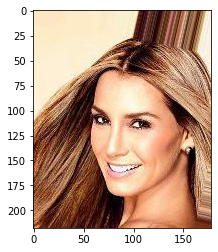

In [9]:
img = Image.open('../../data/celeba/img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [10]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [11]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally
BATCH_SIZE = 256

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='celeba-gender-valid.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='celeba-gender-test.csv',
                             img_dir='../../data/celeba/img_align_celeba/',
                             transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [15]:
target_model = _resnet.ResNet18(2)
#MS_FS
#target_model.load_state_dict(torch.load("../../out/models/PIA_smile/TM(MS30K_FS_30K)_3e_pth", map_location ='cpu'))
#MNS_FNS
target_model.load_state_dict(torch.load("../../out/models/PIA_smile/TM(MS_30K_FNS_30K)_pth", map_location ='cpu'))
#MNS_FS
#target_model.load_state_dict(torch.load("../../out/models/PIA_smile/TM(MNS_30K_FS_30K)_pth", map_location ='cpu'))
#MS_FNS
#target_model.load_state_dict(torch.load("../../out/models/PIA_smile/TM(MS_30K_FNS_30K)_pth", map_location ='cpu'))
#MS_30_MNS_10_FS_30_FNS_10
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MS_30K_MNS_10K_FS_30K_FNS_10K)_pth", map_location ='cpu'))
#MS_10_MNS_30_FS_10_FNS_30
#target_model.load_state_dict(torch.load("../../out/models/PIA_HK/TM(MS_30K_FNS_30K)_3E_HK.pth", map_location ='cpu'))
target_model.eval()
print("Model Loaded")

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "layer2.0.shortcut.0.weight", "layer2.0.shortcut.1.weight", "layer2.0.shortcut.1.bias", "layer2.0.shortcut.1.running_mean", "layer2.0.shortcut.1.running_var", "layer3.0.shortcut.0.weight", "layer3.0.shortcut.1.weight", "layer3.0.shortcut.1.bias", "layer3.0.shortcut.1.running_mean", "layer3.0.shortcut.1.running_var", "layer4.0.shortcut.0.weight", "layer4.0.shortcut.1.weight", "layer4.0.shortcut.1.bias", "layer4.0.shortcut.1.running_mean", "layer4.0.shortcut.1.running_var", "linear.weight", "linear.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked". 
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 3, 3, 3]).

<h1>SHAP Explain</h1>

In [13]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

target_batch = next(iter(test_loader))
target_images, target_labels = target_batch
target_baseline = target_images

non_smiling_male_images = df[(df.Male==1) & (df.Smiling == -1)]
#female_ns = df[(df.Male==0) & (df.Smiling == -1)][:30000]

smiling_female_images = [2,14,26,28,33,35,37,41,42,44]
non_smiling_female_images = [3,4,10,12,15,50,61,63,95,99]

smiling_male_images = [5,19,23,24,27,29,32,40,46,49,54]
#non_smiling_male_images = [51,53,62,97]
    
target_explain = shap.DeepExplainer(target_model, target_baseline)
target_image = target_images[2]
plt.imshow(target_image.numpy()[0])
print(target_labels[0])
print(non_smiling_male_images)

AttributeError: 'tuple' object has no attribute 'device'

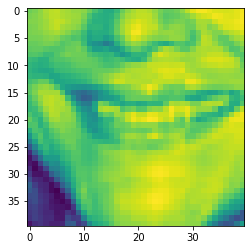

In [1944]:
r_img = torch.tensor([[[0.0 for col in range(128)] for row in range(128)] for dim in range(3)])
r_img = target_image
#z_img = z_img.reshape(1,28,28)
r_img.shape
#plt.imshow(z_img.numpy().squeeze())
plt.imshow(target_image[0:3, 80:120, 40:80].numpy()[0])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 461.20555777359823
shap_sum 309.1962419326683


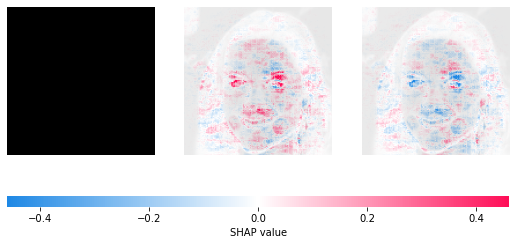

In [1945]:
target_shap_values = shap_plot(target_explain, r_img, 49152)
target_female = torch.tensor(target_shap_values[0]).view(-1) 
target_male = torch.tensor(target_shap_values[1]).view(-1)

###
target_female_crop = torch.tensor(target_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
target_male_crop = torch.tensor(target_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 

<h1>PIA</h1>

In [1946]:
target_female_smile_crop = target_female_crop

In [1947]:
res = sum(target_female_smile_crop - target_female_crop)
res

tensor(0., dtype=torch.float64)

In [1948]:
target_male_smile_crop = target_male_crop

In [1949]:
res = sum(target_male_smile_crop - target_male_crop)
res

tensor(0., dtype=torch.float64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 482.2077364268505
shap_sum 495.8980916384578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 708.8343749740961
shap_sum 842.4645563281565
tensor(-10.2123, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 999.2519227581113
shap_sum 795.2912295425135
tensor(187.3742, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 1009.7657241530035
shap_sum 819.0863815382679
tensor(102.5387, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 888.094781346861
shap_sum 681.2170479260917
tensor(115.3126, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 461.44081908553767
shap_sum 591.3931807931693
tensor(25.3439, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 863.9918327324851
shap_sum 691.5285950017378
tensor(87.9905, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 813.0140492740093
shap_sum 685.4535568511646
tensor(124.3509, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 796.8282961457826
shap_sum 640.6839614345804
tensor(93.0445, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 920.0538046847088
shap_sum 657.6848672983251
tensor(154.7590, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 891.0782216523112
shap_sum 832.1284576262265
tensor(47.9002, dtype=torch.float64)


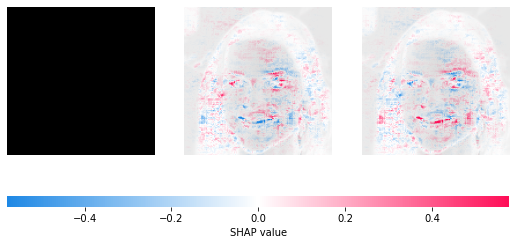

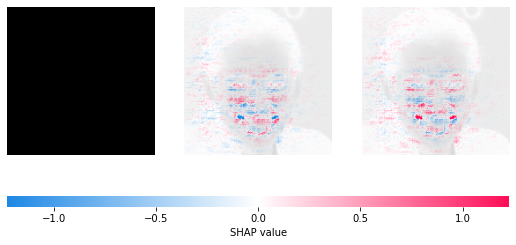

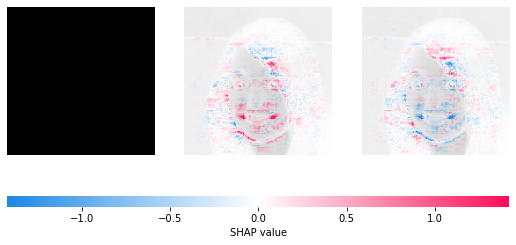

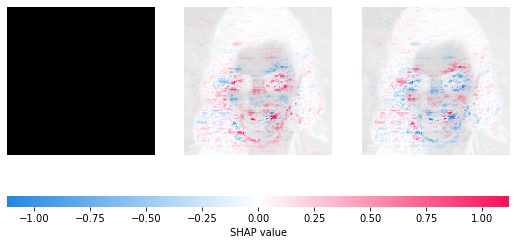

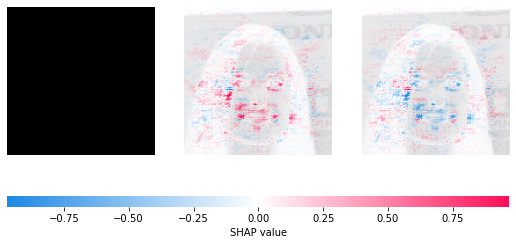

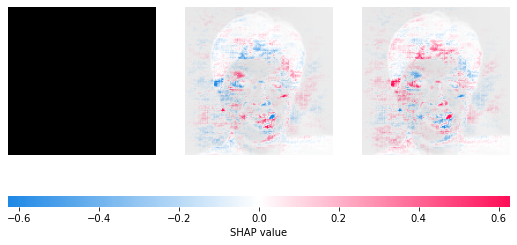

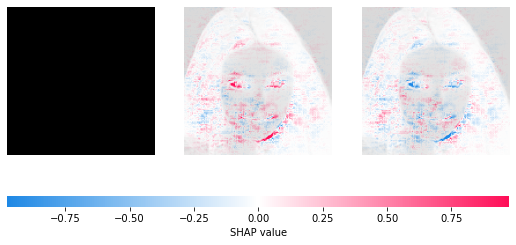

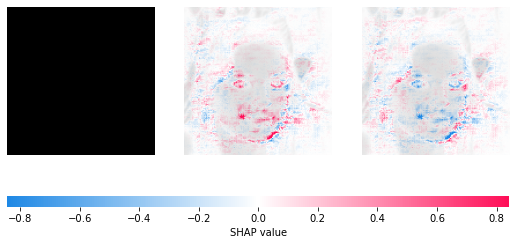

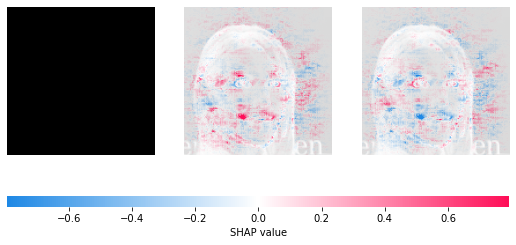

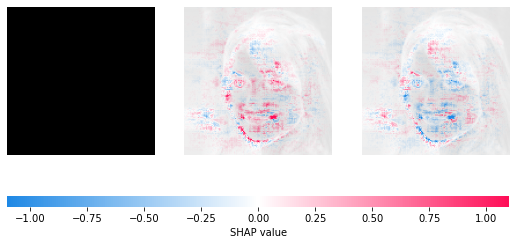

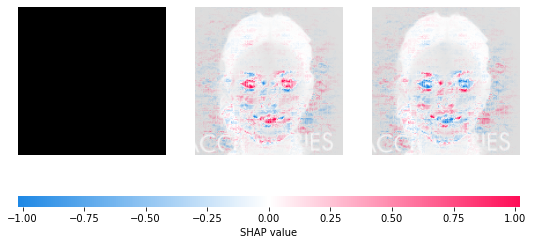

In [1964]:
target_explain = shap.DeepExplainer(target_model, target_baseline)

for smile_female_img in smiling_female_images:
    
    target_image = target_images[smile_female_img]
    r_img = target_image
    target_shap_values = shap_plot(target_explain, r_img, 49152)
    target_female = torch.tensor(target_shap_values[0]).view(-1) 
    #target_male = torch.tensor(target_shap_values[1]).view(-1)
    
    target_smile_female_crop = torch.tensor(target_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
    #target_male_crop = torch.tensor(target_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 
    
    for non_smile_female_img in non_smiling_female_images:
        target_image = target_images[non_smile_female_img]
        r_img = target_image
        target_shap_values = shap_plot(target_explain, r_img, 49152)
        target_female = torch.tensor(target_shap_values[0]).view(-1) 
        #target_male = torch.tensor(target_shap_values[1]).view(-1)

        target_non_smile_female_crop = torch.tensor(target_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
        #target_male_crop = torch.tensor(target_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 
        
        res = sum(target_non_smile_female_crop - target_smile_female_crop)
        print(res)
    
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 858.4694565866573
shap_sum 991.296231415515


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 1028.6597917475483
shap_sum 1071.639272706197
tensor(-25.6635, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 789.4695410003446
shap_sum 1151.0933396078385
tensor(38.0616, dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 824.2536453445714
shap_sum 941.4253850883924
tensor(4.8523, dtype=torch.float64)


KeyboardInterrupt: 

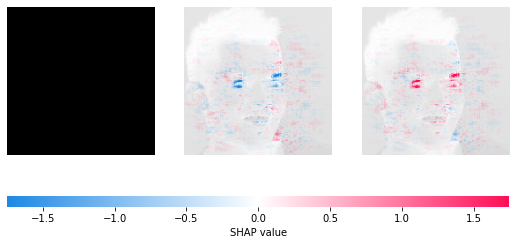

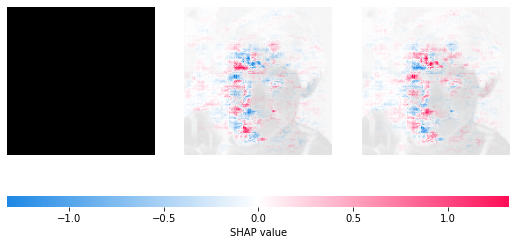

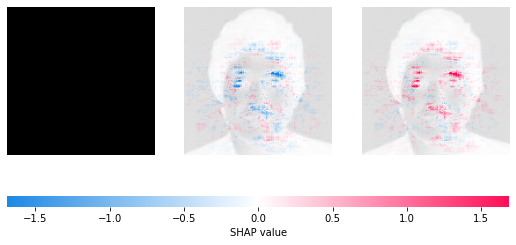

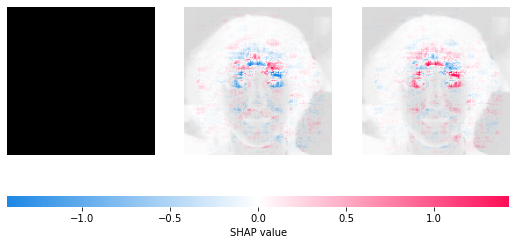

In [1956]:
target_explain = shap.DeepExplainer(target_model, target_baseline)

for smile_male_img in smiling_male_images:
    
    target_image = target_images[smile_male_img]
    r_img = target_image
    target_shap_values = shap_plot(target_explain, r_img, 49152)
    #target_male = torch.tensor(target_shap_values[0]).view(-1) 
    target_male = torch.tensor(target_shap_values[1]).view(-1)
    
    #target_smile_male_crop = torch.tensor(target_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
    target_smile_male_crop = torch.tensor(target_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 
    
    for non_smile_male_img in non_smiling_male_images:
        target_image = target_images[non_smile_male_img]
        r_img = target_image
        target_shap_values = shap_plot(target_explain, r_img, 49152)
        #target_male = torch.tensor(target_shap_values[0]).view(-1) 
        target_male = torch.tensor(target_shap_values[1]).view(-1)

        #target_non_smile_male_crop = torch.tensor(target_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
        target_non_smile_male_crop = torch.tensor(target_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 
        
        res = sum(target_non_smile_male_crop - target_smile_male_crop)
        print(res)
    
    break